In [9]:
import math
import torch
import torchvision
import pandas
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [8]:
train_batch_size =  1000 # Define train batch size
test_batch_size  =  10000 # Define test batch size (can be larger than train batch size)


# Use the following code to load and normalize the dataset
FashionMNIST_dataset = torchvision.datasets.FashionMNIST(
    'files/', train=True, download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]))

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.FashionMNIST(
        'files/', train=False, download=True,
        transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,), (0.3081,))
        ])),
    batch_size=test_batch_size, shuffle=True)

sub_train_size = int(len(FashionMNIST_dataset)*.8)
val_batch_size = len(FashionMNIST_dataset) - sub_train_size

train_dataset, val_dataset = torch.utils.data.random_split(FashionMNIST_dataset, [sub_train_size, val_batch_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False)

In [138]:
# HYPERPARAMS
optimizer_func_list = {
    "SGD": torch.optim.SGD,
    "ADAM": torch.optim.Adam,
    "RMSP": torch.optim.RMSprop,
}
norm_func_list = {
    "L2": lambda x: x.pow(2.0).sum(),
    "L1": lambda x: x.abs().sum(),
}

init_set = {"NORMAL", "KAIMING", "XAVIER", None}

In [179]:
def train_network(nodes, epochs, opt_func, learning_rate, norm_func, reg_lambda, initialization, 
                  dropout, dropout_rate, batch_normalization, layer_normalization):
    if initialization not in init_set:
        raise ValueError

    #Define your network:
    class Network(torch.nn.Module):
        def __init__(self, input_dim, mid_layer):
            super(Network, self).__init__()

            l1nodes = int(mid_layer*4)
            l2nodes = int(mid_layer*2)
            l3nodes = int(mid_layer)
            l4nodes = int(mid_layer/2)

            self.layer1 = [
                torch.nn.Linear(input_dim, l1nodes),
                torch.nn.LeakyReLU(),
            ]
            self.layer2 = [
                torch.nn.Linear(l1nodes, l2nodes),
                torch.nn.LeakyReLU(),
            ]
            self.layer3 = [
                torch.nn.Linear(l2nodes, l3nodes),
                torch.nn.Tanh(),
            ]
            self.layer4 = [
                torch.nn.Linear(l3nodes, l4nodes),
                torch.nn.Tanh(),
            ]
            if batch_normalization:
                self.layer1 += [torch.nn.BatchNorm1d(l1nodes)]
                self.layer2 += [torch.nn.BatchNorm1d(l2nodes)]
                self.layer3 += [torch.nn.BatchNorm1d(l3nodes)]
                self.layer4 += [torch.nn.BatchNorm1d(l4nodes)]
            if layer_normalization:
                self.layer1 += [torch.nn.LayerNorm(l1nodes)]
                self.layer2 += [torch.nn.LayerNorm(l2nodes)]
                self.layer3 += [torch.nn.LayerNorm(l3nodes)]
                self.layer4 += [torch.nn.LayerNorm(l4nodes)]
            if dropout:
                self.layer1 += [torch.nn.Dropout(p=dropout_rate/4)]
                self.layer2 += [torch.nn.Dropout(p=dropout_rate/4)]
                self.layer3 += [torch.nn.Dropout(p=dropout_rate/2)]
                self.layer4 += [torch.nn.Dropout(p=dropout_rate)]

            self.m = torch.nn.Sequential(
                *self.layer1,
                *self.layer2,
                *self.layer3,
                *self.layer4,
                torch.nn.Linear(l4nodes, 10),
            )

            if initialization:
                for mod in self.modules():
                    if isinstance(mod, torch.nn.Linear):
                        if initialization == "NORMAL":
                            mod.weight.data = torch.nn.init.normal_(mod.weight.data)
                        elif initialization == "KAIMING":
                            mod.weight.data = torch.nn.init.kaiming_normal_(mod.weight.data, nonlinearity="relu")
                        elif initialization == "XAVIER":
                            mod.weight.data = torch.nn.init.xavier_normal_(
                                mod.weight.data, 
                                gain=torch.nn.init.calculate_gain("relu"),
                            )


        def forward(self, x):
            return self.m(x)

    model = Network(784, nodes)

    optimizer = optimizer_func_list[opt_func](model.parameters(), lr=learning_rate)

    loss_fn_cel = torch.nn.CrossEntropyLoss()
    def loss_fn(y_hat, y):
        if norm_func is not None:
            norm_val = sum(norm_func_list[norm_func](p) for p in model.parameters())
            norm_val = reg_lambda * norm_val
            loss = loss_fn_cel(y_hat, y) + norm_val
        else:
            loss = loss_fn_cel(y_hat, y)
        return loss

    batch_loss_list = []
    epoch_loss_list = []
    epoch_accuracy_list = []

    for epoch in range(epochs):
        for train_sample, train_label in train_loader:
            train_sample = train_sample.reshape(train_batch_size, 784)
            y_pred = model(train_sample)

            loss = loss_fn(y_pred.squeeze(), train_label)
            batch_loss_list.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # VALIDATION
        with torch.no_grad():
            model.eval()
            val_sample, val_label = next(iter(val_loader))
            val_sample = val_sample.reshape(val_batch_size, 784)
            y_pred = model(val_sample).squeeze()

            accuracy = (torch.argmax(y_pred, dim=1) == val_label).type(torch.FloatTensor).mean()
            loss = loss_fn(y_pred.squeeze(), val_label)

            epoch_accuracy_list.append(accuracy.item())
            epoch_loss_list.append(loss.item())

            print(f"EPOCH: {epoch} Loss {epoch_loss_list[-1]:.4f} ACC {epoch_accuracy_list[-1]:.4f}")
            model.train()

    # TESTING
    with torch.no_grad():
        model.eval()
        test_sample, test_label = next(iter(test_loader))
        test_sample = test_sample.reshape(test_batch_size, 784)
        y_pred = model(test_sample).squeeze()

        accuracy = (torch.argmax(y_pred, dim=1) == test_label).type(torch.FloatTensor).mean()
        loss = loss_fn(y_pred.squeeze(), test_label)

        final_accuracy = accuracy.item()
        final_loss = loss.item()
        print(f"FINAL: Loss {final_loss:.4f} ACC {final_accuracy:.4f}")
        model.train()

    return {
        "final_loss": final_loss,
        "final_accuracy": final_accuracy,
        "loss": pandas.Series(epoch_loss_list),
        "acc": pandas.Series(epoch_accuracy_list),
        "batch_loss": pandas.Series(batch_loss_list),
    }

## 1) Optimizers

In [159]:
res_adam = train_network(
    nodes=100, epochs=10,
    opt_func="ADAM", learning_rate=0.001, 
    norm_func=None, reg_lambda=1e-6, dropout=True, dropout_rate=0.4,
    initialization=None, batch_normalization=False,
)
res_sgd = train_network(
    nodes=100, epochs=10,
    opt_func="SGD", learning_rate=0.001, 
    norm_func=None, reg_lambda=1e-6, dropout=True, dropout_rate=0.4,
    initialization=None, batch_normalization=False,
)
res_rmsp = train_network(
    nodes=100, epochs=10,
    opt_func="RMSP", learning_rate=0.001, 
    norm_func=None, reg_lambda=1e-6, dropout=True, dropout_rate=0.4,
    initialization=None, batch_normalization=False,
)

EPOCH: 0 Loss 0.6250 ACC 0.7841
EPOCH: 1 Loss 0.4767 ACC 0.8367
EPOCH: 2 Loss 0.4074 ACC 0.8588
EPOCH: 3 Loss 0.3725 ACC 0.8694
EPOCH: 4 Loss 0.3510 ACC 0.8769
EPOCH: 5 Loss 0.3442 ACC 0.8786
EPOCH: 6 Loss 0.3288 ACC 0.8879
EPOCH: 7 Loss 0.3350 ACC 0.8842
EPOCH: 8 Loss 0.3120 ACC 0.8912
EPOCH: 9 Loss 0.3162 ACC 0.8891
FINAL: Loss 0.3430 ACC 0.8835
EPOCH: 0 Loss 2.2966 ACC 0.1104
EPOCH: 1 Loss 2.2913 ACC 0.1393
EPOCH: 2 Loss 2.2860 ACC 0.1848
EPOCH: 3 Loss 2.2808 ACC 0.2144
EPOCH: 4 Loss 2.2754 ACC 0.2350
EPOCH: 5 Loss 2.2701 ACC 0.2501
EPOCH: 6 Loss 2.2647 ACC 0.2621
EPOCH: 7 Loss 2.2591 ACC 0.2726
EPOCH: 8 Loss 2.2534 ACC 0.2819
EPOCH: 9 Loss 2.2474 ACC 0.2903
FINAL: Loss 2.2472 ACC 0.2890
EPOCH: 0 Loss 0.6234 ACC 0.7775
EPOCH: 1 Loss 0.5152 ACC 0.8179
EPOCH: 2 Loss 0.4746 ACC 0.8328
EPOCH: 3 Loss 0.4346 ACC 0.8409
EPOCH: 4 Loss 0.4000 ACC 0.8590
EPOCH: 5 Loss 0.3587 ACC 0.8693
EPOCH: 6 Loss 0.3530 ACC 0.8737
EPOCH: 7 Loss 0.3324 ACC 0.8816
EPOCH: 8 Loss 0.3444 ACC 0.8775
EPOCH: 9 Los

,final accuracy
optimizer,
adam,0.8835
sgd,0.2890
rmsprop,0.8666


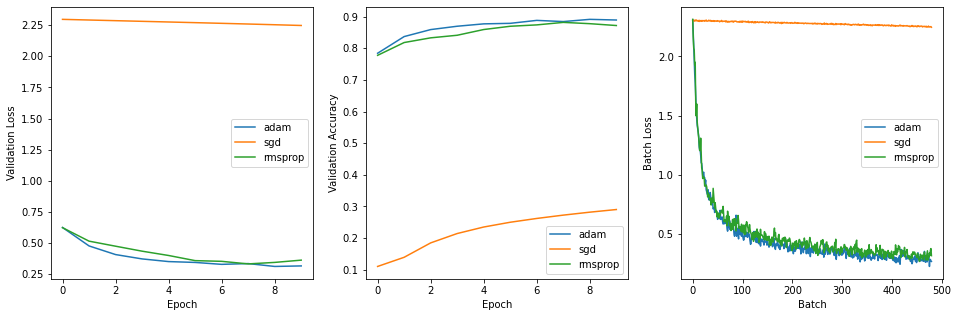

In [172]:
df_final = pandas.DataFrame([
    ("adam", res_adam["final_accuracy"]),
    ("sgd", res_sgd["final_accuracy"]),
    ("rmsprop", res_rmsp["final_accuracy"]),
], columns=["optimizer", "final accuracy"]).set_index("optimizer")
df_loss = pandas.concat([res_adam["loss"].rename("adam"), res_sgd["loss"].rename("sgd"), res_rmsp["loss"].rename("rmsprop")], axis=1)
df_acc = pandas.concat([res_adam["acc"].rename("adam"), res_sgd["acc"].rename("sgd"), res_rmsp["acc"].rename("rmsprop")], axis=1)
df_batch_loss = pandas.concat([res_adam["batch_loss"].rename("adam"), res_sgd["batch_loss"].rename("sgd"), res_rmsp["batch_loss"].rename("rmsprop")], axis=1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

df_loss.plot(ax=ax1)
ax1.set_ylabel("Validation Loss")
ax1.set_xlabel("Epoch")

df_acc.plot(ax=ax2)
ax2.set_ylabel("Validation Accuracy")
ax2.set_xlabel("Epoch")

df_batch_loss.plot(ax=ax3)
ax3.set_ylabel("Batch Loss")
ax3.set_xlabel("Batch")

df_final

## 2) Regularization

In [163]:
res_l1 = train_network(
    nodes=100, epochs=10,
    opt_func="ADAM", learning_rate=0.001, 
    norm_func="L1", reg_lambda=1e-3, dropout=False, dropout_rate=0.4,
    initialization=None, batch_normalization=False,
)
res_l2 = train_network(
    nodes=100, epochs=10,
    opt_func="ADAM", learning_rate=0.001,
    norm_func="L2", reg_lambda=1e-3, dropout=False, dropout_rate=0.4,
    initialization=None, batch_normalization=False,
)
res_dropout = train_network(
    nodes=100, epochs=10,
    opt_func="ADAM", learning_rate=0.001, 
    norm_func=None, reg_lambda=1e-6, dropout=True, dropout_rate=0.4,
    initialization=None, batch_normalization=False,
)

EPOCH: 0 Loss 2.1157 ACC 0.5646
EPOCH: 1 Loss 1.4573 ACC 0.7164
EPOCH: 2 Loss 1.2839 ACC 0.7490
EPOCH: 3 Loss 1.1906 ACC 0.7607
EPOCH: 4 Loss 1.1386 ACC 0.7741
EPOCH: 5 Loss 1.1153 ACC 0.7678
EPOCH: 6 Loss 1.0465 ACC 0.7849
EPOCH: 7 Loss 1.0277 ACC 0.7908
EPOCH: 8 Loss 1.0056 ACC 0.7917
EPOCH: 9 Loss 0.9877 ACC 0.7962
FINAL: Loss 1.0012 ACC 0.7917
EPOCH: 0 Loss 0.7966 ACC 0.8181
EPOCH: 1 Loss 0.6306 ACC 0.8449
EPOCH: 2 Loss 0.5658 ACC 0.8567
EPOCH: 3 Loss 0.5241 ACC 0.8668
EPOCH: 4 Loss 0.5300 ACC 0.8627
EPOCH: 5 Loss 0.5032 ACC 0.8686
EPOCH: 6 Loss 0.4811 ACC 0.8744
EPOCH: 7 Loss 0.4823 ACC 0.8762
EPOCH: 8 Loss 0.4938 ACC 0.8686
EPOCH: 9 Loss 0.4581 ACC 0.8807
FINAL: Loss 0.4810 ACC 0.8727
EPOCH: 0 Loss 0.6294 ACC 0.7888
EPOCH: 1 Loss 0.4689 ACC 0.8393
EPOCH: 2 Loss 0.4053 ACC 0.8583
EPOCH: 3 Loss 0.3712 ACC 0.8709
EPOCH: 4 Loss 0.3638 ACC 0.8739
EPOCH: 5 Loss 0.3528 ACC 0.8777
EPOCH: 6 Loss 0.3343 ACC 0.8836
EPOCH: 7 Loss 0.3374 ACC 0.8810
EPOCH: 8 Loss 0.3358 ACC 0.8835
EPOCH: 9 Los

,final accuracy
regularizer,
L1,0.7917
L2,0.8727
dropout,0.8799


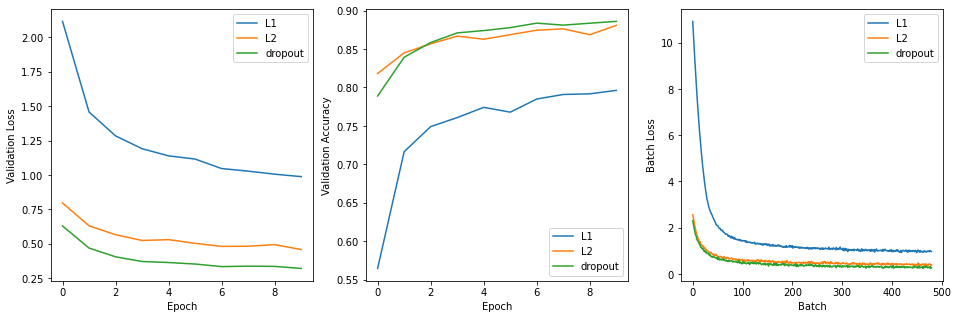

In [173]:
df_final = pandas.DataFrame([
    ("L1", res_l1["final_accuracy"]),
    ("L2", res_l2["final_accuracy"]),
    ("dropout", res_dropout["final_accuracy"]),
], columns=["regularizer", "final accuracy"]).set_index("regularizer")
df_loss = pandas.concat([res_l1["loss"].rename("L1"), res_l2["loss"].rename("L2"), res_dropout["loss"].rename("dropout")], axis=1)
df_acc = pandas.concat([res_l1["acc"].rename("L1"), res_l2["acc"].rename("L2"), res_dropout["acc"].rename("dropout")], axis=1)
df_batch_loss = pandas.concat([res_l1["batch_loss"].rename("L1"), res_l2["batch_loss"].rename("L2"), res_dropout["batch_loss"].rename("dropout")], axis=1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

df_loss.plot(ax=ax1)
ax1.set_ylabel("Validation Loss")
ax1.set_xlabel("Epoch")

df_acc.plot(ax=ax2)
ax2.set_ylabel("Validation Accuracy")
ax2.set_xlabel("Epoch")

df_batch_loss.plot(ax=ax3)
ax3.set_ylabel("Batch Loss")
ax3.set_xlabel("Batch")

df_final

## 3) Initialization

In [177]:
res_default = train_network(
    nodes=100, epochs=10,
    opt_func="ADAM", learning_rate=0.001, 
    norm_func=None, reg_lambda=1e-6, dropout=True, dropout_rate=0.4,
    initialization=None, batch_normalization=False,
)
res_normal = train_network(
    nodes=100, epochs=10,
    opt_func="ADAM", learning_rate=0.001, 
    norm_func=None, reg_lambda=1e-6, dropout=True, dropout_rate=0.4,
    initialization="NORMAL", batch_normalization=False,
)
res_kaiming = train_network(
    nodes=100, epochs=10,
    opt_func="ADAM", learning_rate=0.001, 
    norm_func=None, reg_lambda=1e-6, dropout=True, dropout_rate=0.4,
    initialization="KAIMING", batch_normalization=False,
)
res_xavier = train_network(
    nodes=100, epochs=10,
    opt_func="ADAM", learning_rate=0.001, 
    norm_func=None, reg_lambda=1e-6, dropout=True, dropout_rate=0.4,
    initialization="XAVIER", batch_normalization=False,
)

EPOCH: 0 Loss 0.6438 ACC 0.7865
EPOCH: 1 Loss 0.4703 ACC 0.8418
EPOCH: 2 Loss 0.4003 ACC 0.8612
EPOCH: 3 Loss 0.3829 ACC 0.8690
EPOCH: 4 Loss 0.3642 ACC 0.8717
EPOCH: 5 Loss 0.3411 ACC 0.8795
EPOCH: 6 Loss 0.3339 ACC 0.8847
EPOCH: 7 Loss 0.3341 ACC 0.8836
EPOCH: 8 Loss 0.3177 ACC 0.8893
EPOCH: 9 Loss 0.3305 ACC 0.8835
FINAL: Loss 0.3544 ACC 0.8782
EPOCH: 0 Loss 8.1956 ACC 0.1157
EPOCH: 1 Loss 6.5418 ACC 0.1637
EPOCH: 2 Loss 5.3153 ACC 0.2173
EPOCH: 3 Loss 4.4405 ACC 0.2558
EPOCH: 4 Loss 3.8176 ACC 0.2863
EPOCH: 5 Loss 3.3953 ACC 0.3158
EPOCH: 6 Loss 3.0606 ACC 0.3482
EPOCH: 7 Loss 2.7830 ACC 0.3737
EPOCH: 8 Loss 2.5214 ACC 0.4017
EPOCH: 9 Loss 2.2035 ACC 0.4306
FINAL: Loss 2.2440 ACC 0.4316
EPOCH: 0 Loss 0.4963 ACC 0.8287
EPOCH: 1 Loss 0.4166 ACC 0.8558
EPOCH: 2 Loss 0.3892 ACC 0.8612
EPOCH: 3 Loss 0.3735 ACC 0.8699
EPOCH: 4 Loss 0.3438 ACC 0.8806
EPOCH: 5 Loss 0.3308 ACC 0.8818
EPOCH: 6 Loss 0.3420 ACC 0.8787
EPOCH: 7 Loss 0.3280 ACC 0.8857
EPOCH: 8 Loss 0.3227 ACC 0.8868
EPOCH: 9 Los

,final accuracy
initializer,
default,0.8782
normal,0.4316
kaiming,0.8811
xavier,0.8781


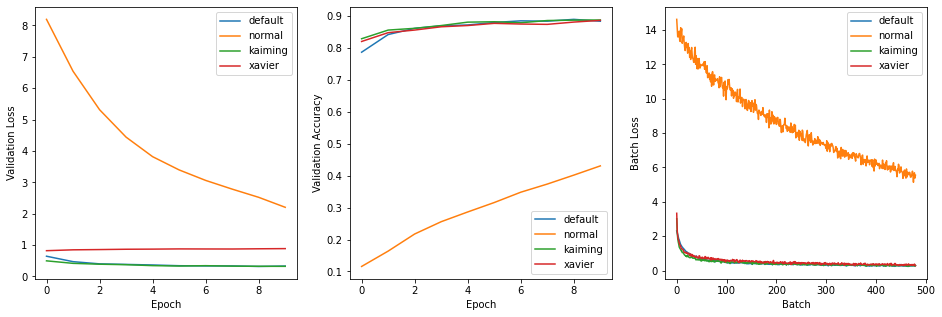

In [178]:
df_final = pandas.DataFrame([
    ("default", res_default["final_accuracy"]),
    ("normal", res_normal["final_accuracy"]),
    ("kaiming", res_kaiming["final_accuracy"]),
    ("xavier", res_xavier["final_accuracy"]),
], columns=["initializer", "final accuracy"]).set_index("initializer")
df_loss = pandas.concat([res_default["loss"].rename("default"), res_normal["loss"].rename("normal"),
                         res_kaiming["loss"].rename("kaiming"), res_xavier["acc"].rename("xavier")], axis=1)
df_acc = pandas.concat([res_default["acc"].rename("default"), res_normal["acc"].rename("normal"),
                        res_kaiming["acc"].rename("kaiming"), res_xavier["acc"].rename("xavier")], axis=1)
df_batch_loss = pandas.concat([res_default["batch_loss"].rename("default"), res_normal["batch_loss"].rename("normal"), 
                               res_kaiming["batch_loss"].rename("kaiming"), res_xavier["batch_loss"].rename("xavier")], axis=1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

df_loss.plot(ax=ax1)
ax1.set_ylabel("Validation Loss")
ax1.set_xlabel("Epoch")

df_acc.plot(ax=ax2)
ax2.set_ylabel("Validation Accuracy")
ax2.set_xlabel("Epoch")

df_batch_loss.plot(ax=ax3)
ax3.set_ylabel("Batch Loss")
ax3.set_xlabel("Batch")

df_final

## 4) Batch Normalization

In [182]:
res_default_norm = train_network(
    nodes=100, epochs=10,
    opt_func="ADAM", learning_rate=0.001, 
    norm_func=None, reg_lambda=1e-6, dropout=True, dropout_rate=0.4,
    initialization=None, batch_normalization=False, layer_normalization=False,
)
res_batch = train_network(
    nodes=100, epochs=10,
    opt_func="ADAM", learning_rate=0.001, 
    norm_func=None, reg_lambda=1e-6, dropout=True, dropout_rate=0.4,
    initialization="KAIMING", batch_normalization=True,  layer_normalization=False,
)
res_layer = train_network(
    nodes=100, epochs=10,
    opt_func="ADAM", learning_rate=0.001, 
    norm_func=None, reg_lambda=1e-6, dropout=True, dropout_rate=0.4,
    initialization="KAIMING", batch_normalization=False, layer_normalization=True,
)

EPOCH: 0 Loss 0.6174 ACC 0.8041
EPOCH: 1 Loss 0.4446 ACC 0.8499
EPOCH: 2 Loss 0.3978 ACC 0.8612
EPOCH: 3 Loss 0.3779 ACC 0.8693
EPOCH: 4 Loss 0.3464 ACC 0.8768
EPOCH: 5 Loss 0.3368 ACC 0.8812
EPOCH: 6 Loss 0.3241 ACC 0.8865
EPOCH: 7 Loss 0.3337 ACC 0.8841
EPOCH: 8 Loss 0.3264 ACC 0.8878
EPOCH: 9 Loss 0.3145 ACC 0.8907
FINAL: Loss 0.3462 ACC 0.8811
EPOCH: 0 Loss 0.4900 ACC 0.8339
EPOCH: 1 Loss 0.4156 ACC 0.8581
EPOCH: 2 Loss 0.3816 ACC 0.8663
EPOCH: 3 Loss 0.3661 ACC 0.8723
EPOCH: 4 Loss 0.3505 ACC 0.8765
EPOCH: 5 Loss 0.3395 ACC 0.8795
EPOCH: 6 Loss 0.3341 ACC 0.8803
EPOCH: 7 Loss 0.3396 ACC 0.8790
EPOCH: 8 Loss 0.3357 ACC 0.8819
EPOCH: 9 Loss 0.3456 ACC 0.8809
FINAL: Loss 0.3722 ACC 0.8743
EPOCH: 0 Loss 0.5215 ACC 0.8202
EPOCH: 1 Loss 0.4477 ACC 0.8437
EPOCH: 2 Loss 0.4049 ACC 0.8593
EPOCH: 3 Loss 0.3900 ACC 0.8662
EPOCH: 4 Loss 0.3880 ACC 0.8694
EPOCH: 5 Loss 0.3715 ACC 0.8744
EPOCH: 6 Loss 0.3618 ACC 0.8748
EPOCH: 7 Loss 0.3457 ACC 0.8825
EPOCH: 8 Loss 0.3584 ACC 0.8779
EPOCH: 9 Los

,final accuracy
normalization,
default,0.8811
batch,0.8743
layer,0.8766


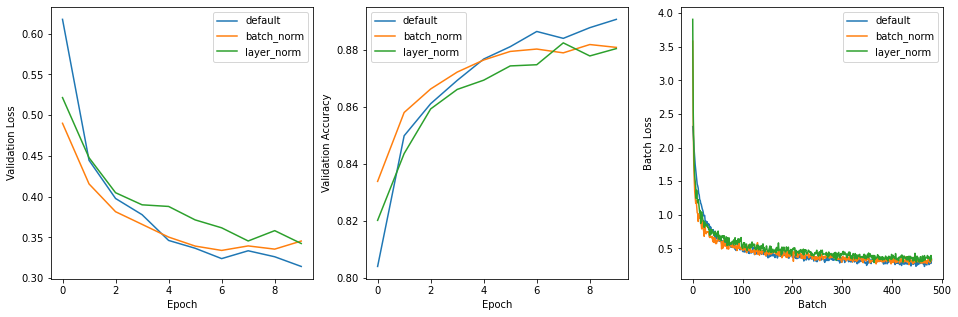

In [183]:
df_final = pandas.DataFrame([
    ("default", res_default_norm["final_accuracy"]),
    ("batch", res_batch["final_accuracy"]),
    ("layer", res_layer["final_accuracy"]),
], columns=["normalization", "final accuracy"]).set_index("normalization")
df_loss = pandas.concat([
    res_default_norm["loss"].rename("default"), 
    res_batch["loss"].rename("batch_norm"),
    res_layer["loss"].rename("layer_norm"),
], axis=1)
df_acc = pandas.concat([
    res_default_norm["acc"].rename("default"),
    res_batch["acc"].rename("batch_norm"),
    res_layer["acc"].rename("layer_norm"),
], axis=1)
df_batch_loss = pandas.concat([
    res_default_norm["batch_loss"].rename("default"),
    res_batch["batch_loss"].rename("batch_norm"),
    res_layer["batch_loss"].rename("layer_norm"),
], axis=1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

df_loss.plot(ax=ax1)
ax1.set_ylabel("Validation Loss")
ax1.set_xlabel("Epoch")

df_acc.plot(ax=ax2)
ax2.set_ylabel("Validation Accuracy")
ax2.set_xlabel("Epoch")

df_batch_loss.plot(ax=ax3)
ax3.set_ylabel("Batch Loss")
ax3.set_xlabel("Batch")

df_final

In [148]:
print("BEST")
print(f"FINAL: Loss {final_loss:.4f} ACC {final_accuracy:.4f}")
print("nodes", nodes)
print("opt_func", opt_func)
print("learning_rate", learning_rate)
print("epochs", epochs)
print("norm_func", norm_func)
print("reg_lambda", reg_lambda)
print("batch_normalization", batch_normalization)
print("dropout", dropout)
print("dropout_rate", dropout_rate)

BEST
FINAL: Loss 0.3588 ACC 0.8924
nodes 100
opt_func ADAM
learning_rate 0.001
epochs 25
norm_func L2
reg_lambda 1e-06
batch_normalization False
dropout True
dropout_rate 0.4


Text(0.5, 0, 'Batch')

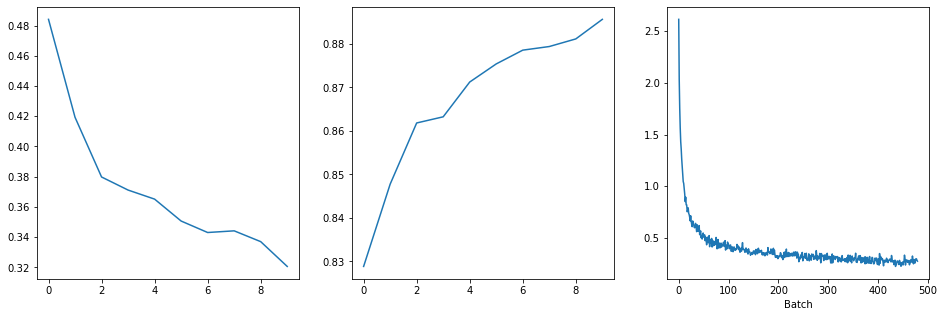

In [87]:
df_batch_loss = pandas.Series(batch_loss_list)
df_epoch_loss = pandas.Series(epoch_loss_list)
df_epoch_acc = pandas.Series(epoch_accuracy_list)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
df_epoch_loss.plot(ax=ax1)
ax1.set_xlabel("EPOCH")
ax1.set_ylabel("Loss")

df_epoch_acc.plot(ax=ax2)
ax2.set_xlabel("EPOCH")
ax2.set_ylabel("Accuracy")

df_batch_loss.plot(ax=ax3)
ax3.set_xlabel("Batch")
ax3.set_ylabel("Loss")